# Malware Detection in Network Traffic Data

## Введение

Над проектом работают: **Шевцов Владислав**, **Иващенко Дмитрий**.

### Постановка задачи

В данном проекте исследуется датасет [Malware Detection in Network Traffic Data](https://www.kaggle.com/datasets/agungpambudi/network-malware-detection-connection-analysis).

Необходимо построить модель машинного обучения, которая по метаданным каждого сетевого потока классифицирует трафик как "нормальный" и "вредоносный".

### Цели исследования

1. Разведочный анализ и подготовка данных:
	* отобрать ключевой набор признаков
	* обработать пропуски, закодировать категориальные признаки
	* изучить распределения признаков, зависимости и оценить корреляции признаков с целевой переменной
2. Построение и сравнение трёх алгоритмов:
	* логистическая регрессия
	* k-NN
	* XGBoost
3. Оценка качества моделей.
4. Выбор финальной модели и рекомендации.

### О данных

* Каждая строка описывает сетевой поток с более чем 20 атрибутами: IP-адреса и порты, протокол, длительность, счётчики пакетов/байтов, состояние сеанса и др.
* Датасет снабжён двумя уровнями разметки:
	+ `label` — **Benign** или **Malicious** (будет целевой переменной);
	+ `detailed-label` — 10 конкретных подтипов атак (используются лишь для валидации и анализа ошибок, но не для обучения).

## Разведочный анализ данных (EDA)

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.dpi'] = 300
plt.style.use('seaborn-v0_8-whitegrid')

### Загрузка данных

In [2]:
df = pd.read_csv('dataset/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv', delimiter='|')

df.shape

(1008748, 23)

### Первичный обзор структуры датасета

In [3]:
display(df.sample(5, random_state=42))

df.info()

ts                 uid        id.orig_h  id.orig_p  \
344375  1.526010e+09  Cq6FWN3Ywzs95oALG2  192.168.100.103    53854.0   
883270  1.526229e+09  Co0sIV2OSOJECc0jE3  192.168.100.103    36495.0   
94977   1.525915e+09  C4rbZX3Ybr3osgdch6  192.168.100.103    56144.0   
552763  1.526090e+09  Cw5ilM1d22NAOq9zR1  192.168.100.103    43763.0   
796999  1.526191e+09  CWBbvj2n84ONnUk1Pg  192.168.100.103    40038.0   

              id.resp_h  id.resp_p proto service  duration orig_bytes  ...  \
344375    120.10.164.48       23.0   tcp       -         -          -  ...   
883270   61.182.158.196     9527.0   tcp       -         -          -  ...   
94977    107.159.11.133     9527.0   tcp       -  0.998941          0  ...   
552763  172.180.210.202    41534.0   udp       -         -          -  ...   
796999  134.153.182.254     2323.0   tcp       -         -          -  ...   

       local_resp missed_bytes history orig_pkts  orig_ip_bytes resp_pkts  \
344375          -          0.0       S       1.0           60.0       0.0   
883270          -          0.0       S       1.0           60.0       0.0   
94977           -          0.0       S       2.0          120.0       0.0   
552763          -          0.0       D       1.0           40.0       0.0   
796999          -          0.0       S       1.0           60.0       0.0   

        resp_ip_bytes  tunnel_parents      label             detailed-label  
344375            0.0               -  Malicious  PartOfAHorizontalPortScan  
883270            0.0               -  Malicious  PartOfAHorizontalPortScan  
94977             0.0               -  Malicious  PartOfAHorizontalPortScan  
552763            0.0               -     Benign                          -  
796999            0.0               -  Malicious  PartOfAHorizontalPortScan  

[5 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 0 to 1008747
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ts              1008748 non-null  float64
 1   uid             1008748 non-null  object 
 2   id.orig_h       1008748 non-null  object 
 3   id.orig_p       1008748 non-null  float64
 4   id.resp_h       1008748 non-null  object 
 5   id.resp_p       1008748 non-null  float64
 6   proto           1008748 non-null  object 
 7   service         1008748 non-null  object 
 8   duration        1008748 non-null  object 
 9   orig_bytes      1008748 non-null  object 
 10  resp_bytes      1008748 non-null  object 
 11  conn_state      1008748 non-null  object 
 12  local_orig      1008748 non-null  object 
 13  local_resp      1008748 non-null  object 
 14  missed_bytes    1008748 non-null  float64
 15  history         1008748 non-null  object 
 16  orig_pkts       1008748 non-null  fl

### Предобработка данных

Начнём с того, что сразу же удалим столбцы, которые вряд ли могут пригодиться, а именно:
* `ts` - временная метка события подключения.
* `uid` - уникальный идентификатор соединения.
* `id.orig_h` - 
* `id.resp_h` - 
* `local_orig` и `local_resp` - указывает, считается ли соединение локальным или нет.
* `missed_bytes` - количество пропущенных байтов в соединении.
* `tunnel_parents` - указывает, является ли это соединение частью туннеля.
* `detailed-label` - более подробное описание или метка соединения.

In [4]:
cols_to_del = [
    'ts',
    'uid',
    'id.orig_h',
    'id.resp_h',
    'local_orig',
    'local_resp',
    'missed_bytes',
    'tunnel_parents',
    'detailed-label'
]

df_copy = df.drop(columns=cols_to_del)

In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 0 to 1008747
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id.orig_p      1008748 non-null  float64
 1   id.resp_p      1008748 non-null  float64
 2   proto          1008748 non-null  object 
 3   service        1008748 non-null  object 
 4   duration       1008748 non-null  object 
 5   orig_bytes     1008748 non-null  object 
 6   resp_bytes     1008748 non-null  object 
 7   conn_state     1008748 non-null  object 
 8   history        1008748 non-null  object 
 9   orig_pkts      1008748 non-null  float64
 10  orig_ip_bytes  1008748 non-null  float64
 11  resp_pkts      1008748 non-null  float64
 12  resp_ip_bytes  1008748 non-null  float64
 13  label          1008748 non-null  object 
dtypes: float64(6), object(8)
memory usage: 107.7+ MB


Далее наведём порядок по типу данных для каждого столбца:

In [6]:
for col in df_copy.columns:
    print(df_copy[col].value_counts())

id.orig_p
43763.0    399650
3.0         14516
123.0        8551
11.0         2903
23.0          158
            ...  
22702.0         1
25927.0         1
8.0             1
448.0           1
61878.0         1
Name: count, Length: 28243, dtype: int64
id.resp_p
23.0       271561
8080.0     135382
2323.0      88184
9527.0      44338
123.0        8553
            ...  
58082.0         1
302.0           1
39167.0         1
49567.0         1
24172.0         1
Name: count, Length: 65426, dtype: int64
proto
tcp     583134
udp     408193
icmp     17421
Name: count, dtype: int64
service
-       1005507
http       3238
dhcp          1
ssh           1
dns           1
Name: count, dtype: int64
duration
-            796300
2.998791       4494
2.998792       4342
2.998790       4167
2.998793       3836
              ...  
12.791694         1
11.271063         1
11.251074         1
11.324040         1
11.969152         1
Name: count, Length: 16650, dtype: int64
orig_bytes
-       796300
0       195511


In [7]:
df_copy['id.orig_p'] = df_copy['id.orig_p'].astype('int64')

df_copy['id.resp_p'] = df_copy['id.resp_p'].astype('int64')

df_copy['proto'] = df_copy['proto'].astype('string')

df_copy['service'] = df_copy['service'].astype('string')

df_copy['duration'] = df_copy['duration'].astype('string')
df_copy['duration'] = df_copy['duration'].replace('-', '-1')
df_copy['duration'] = df_copy['duration'].astype('float64')

df_copy['orig_bytes'] = df_copy['orig_bytes'].astype('string')
df_copy['orig_bytes'] = df_copy['orig_bytes'].replace('-', '-1')
df_copy['orig_bytes'] = df_copy['orig_bytes'].astype('int64')

df_copy['resp_bytes'] = df_copy['resp_bytes'].astype('string')
df_copy['resp_bytes'] = df_copy['resp_bytes'].replace('-', '-1')
df_copy['resp_bytes'] = df_copy['resp_bytes'].astype('int64')

df_copy['conn_state'] = df_copy['conn_state'].astype('string')

df_copy['history'] = df_copy['history'].astype('string')

df_copy['orig_pkts'] = df_copy['orig_pkts'].astype('int64')

df_copy['orig_ip_bytes'] = df_copy['orig_ip_bytes'].astype('int64')

df_copy['resp_pkts'] = df_copy['resp_pkts'].astype('int64')

df_copy['resp_ip_bytes'] = df_copy['resp_ip_bytes'].astype('int64')

df_copy['label'] = df_copy['label'].astype('string')

Теперь выделим отдельно `label`:

In [8]:
df_label = df_copy[['label']].copy()

Осталось лишь закодировать `proto`, `service`, `conn_state` и `history`. Будем использовать два подхода: `OrdinalEncoder` и `OneHotEncoder`.

In [9]:
cat_cols = ['proto', 'service', 'conn_state', 'history']

In [10]:
from sklearn.preprocessing import OrdinalEncoder

df_enc = df_copy.copy()
df_enc = df_enc.drop(columns=['label'])

print('Before ordinal encoding:')
print(df_enc.values[0])
print(df_enc.shape)

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_enc[cat_cols] = enc.fit_transform(df_enc[cat_cols])

print('After ordinal encoding:')
print(df_enc.values[0])
print(df_enc.shape)

Before ordinal encoding:
[51524 23 'tcp' '-' 2.999051 0 0 'S0' 'S' 3 180 0 0]
(1008748, 13)
After ordinal encoding:
[5.152400e+04 2.300000e+01 1.000000e+00 0.000000e+00 2.999051e+00
 0.000000e+00 0.000000e+00 6.000000e+00 2.200000e+01 3.000000e+00
 1.800000e+02 0.000000e+00 0.000000e+00]
(1008748, 13)


In [11]:
from sklearn.preprocessing import OneHotEncoder

df_ohe = df_copy.copy()
df_ohe = df_ohe.drop(columns=['label'])

print('Before one-hot encoding:')
print(df_ohe.values[0])
print(df_ohe.shape)

ohe = OneHotEncoder(handle_unknown='ignore',
                    sparse_output=False,
                    dtype='int8',
                    min_frequency=120,
                    drop='first'
      )

encoded = ohe.fit_transform(df_ohe[cat_cols])

new_cols = ohe.get_feature_names_out(cat_cols)

encoded_df = pd.DataFrame(encoded, columns=new_cols, index=df_ohe.index)

df_ohe = pd.concat([df_ohe.drop(columns=cat_cols), encoded_df], axis=1)

print('After one-hot encoding:')
print(df_ohe.values[0])
print(df_ohe.shape)

Before one-hot encoding:
[51524 23 'tcp' '-' 2.999051 0 0 'S0' 'S' 3 180 0 0]
(1008748, 13)
After one-hot encoding:
[5.152400e+04 2.300000e+01 2.999051e+00 0.000000e+00 0.000000e+00
 3.000000e+00 1.800000e+02 0.000000e+00 0.000000e+00 1.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00]
(1008748, 38)


Итак, теперь мы имеем:
* `df_copy` - предобработанные данные без кодирования `string` данных и со столбцом `label` (это будет удобно для визуализации).
* `df_enc` - предобработанные данные с `OrdinalEncoder`.
* `df_ohe` - предобработанные данные с `OneHotEncoder`.
* `df_label` - метки.

In [12]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 0 to 1008747
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id.orig_p      1008748 non-null  int64  
 1   id.resp_p      1008748 non-null  int64  
 2   proto          1008748 non-null  string 
 3   service        1008748 non-null  string 
 4   duration       1008748 non-null  float64
 5   orig_bytes     1008748 non-null  int64  
 6   resp_bytes     1008748 non-null  int64  
 7   conn_state     1008748 non-null  string 
 8   history        1008748 non-null  string 
 9   orig_pkts      1008748 non-null  int64  
 10  orig_ip_bytes  1008748 non-null  int64  
 11  resp_pkts      1008748 non-null  int64  
 12  resp_ip_bytes  1008748 non-null  int64  
 13  label          1008748 non-null  string 
dtypes: float64(1), int64(8), string(5)
memory usage: 107.7 MB


### Анализ данных

#### Распределение целевого признака

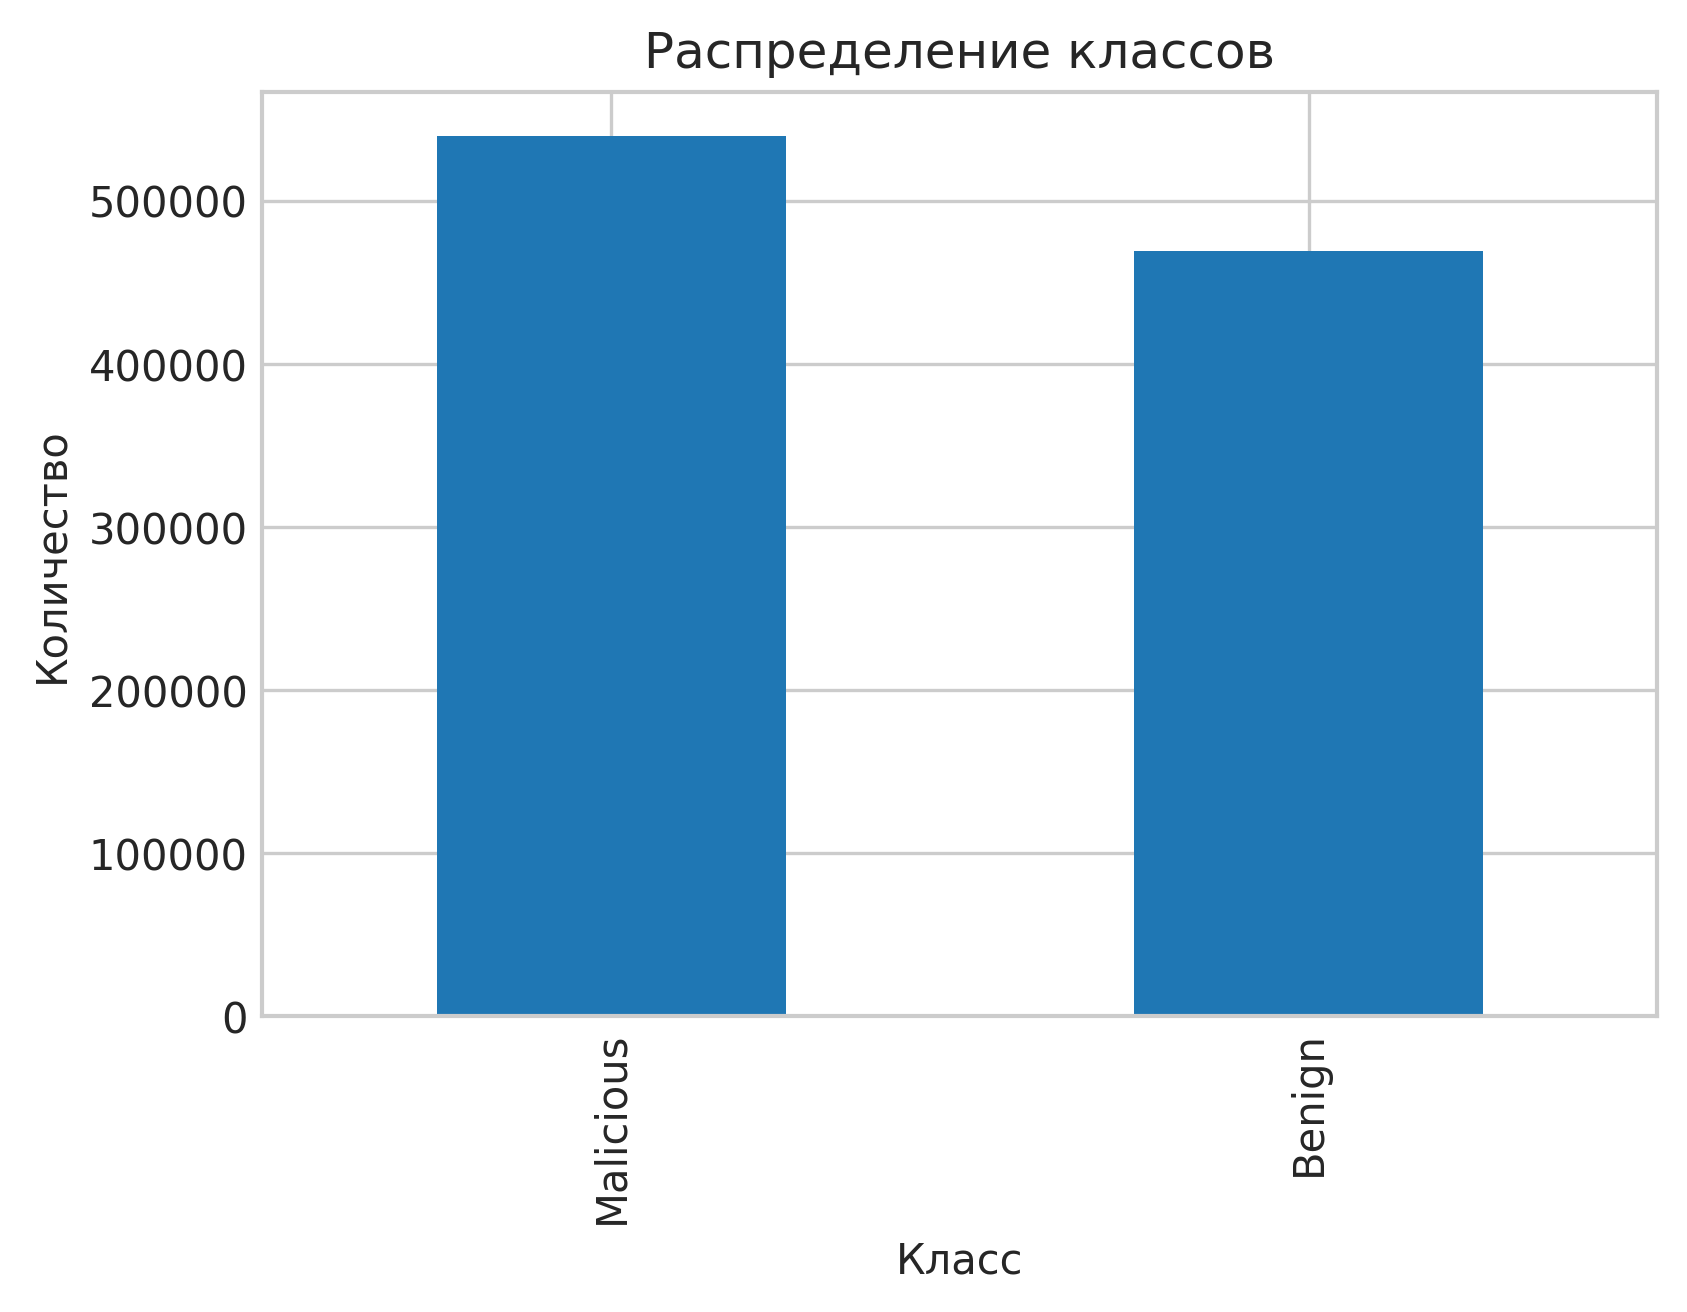

In [13]:
df_label['label'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

Отсюда можно сделать вывод, что не придётся бороться с явным дисбалансом классов (хотя с метриками даже при небольшом дисбалансе надо быть аккуратнее). 

#### Распределения категориальных признаков

In [14]:
cat_cols = ['proto', 'service', 'conn_state', 'history']

TOP_N = 10

count_tables = {}
rate_tables = {}

for col in cat_cols:
    # Берём TOP_N категорий по общему количеству
    top_vals = df_copy[col].value_counts().nlargest(TOP_N).index
    sub = df_copy[df_copy[col].isin(top_vals)]
    
    # Абсолютные частоты
    counts = pd.crosstab(sub[col], sub['label']).reindex(top_vals)
    count_tables[col] = counts
    
    # Доля Malicious
    rates = counts.div(counts.sum(axis=1), axis=0)['Malicious']
    rate_tables[col] = rates

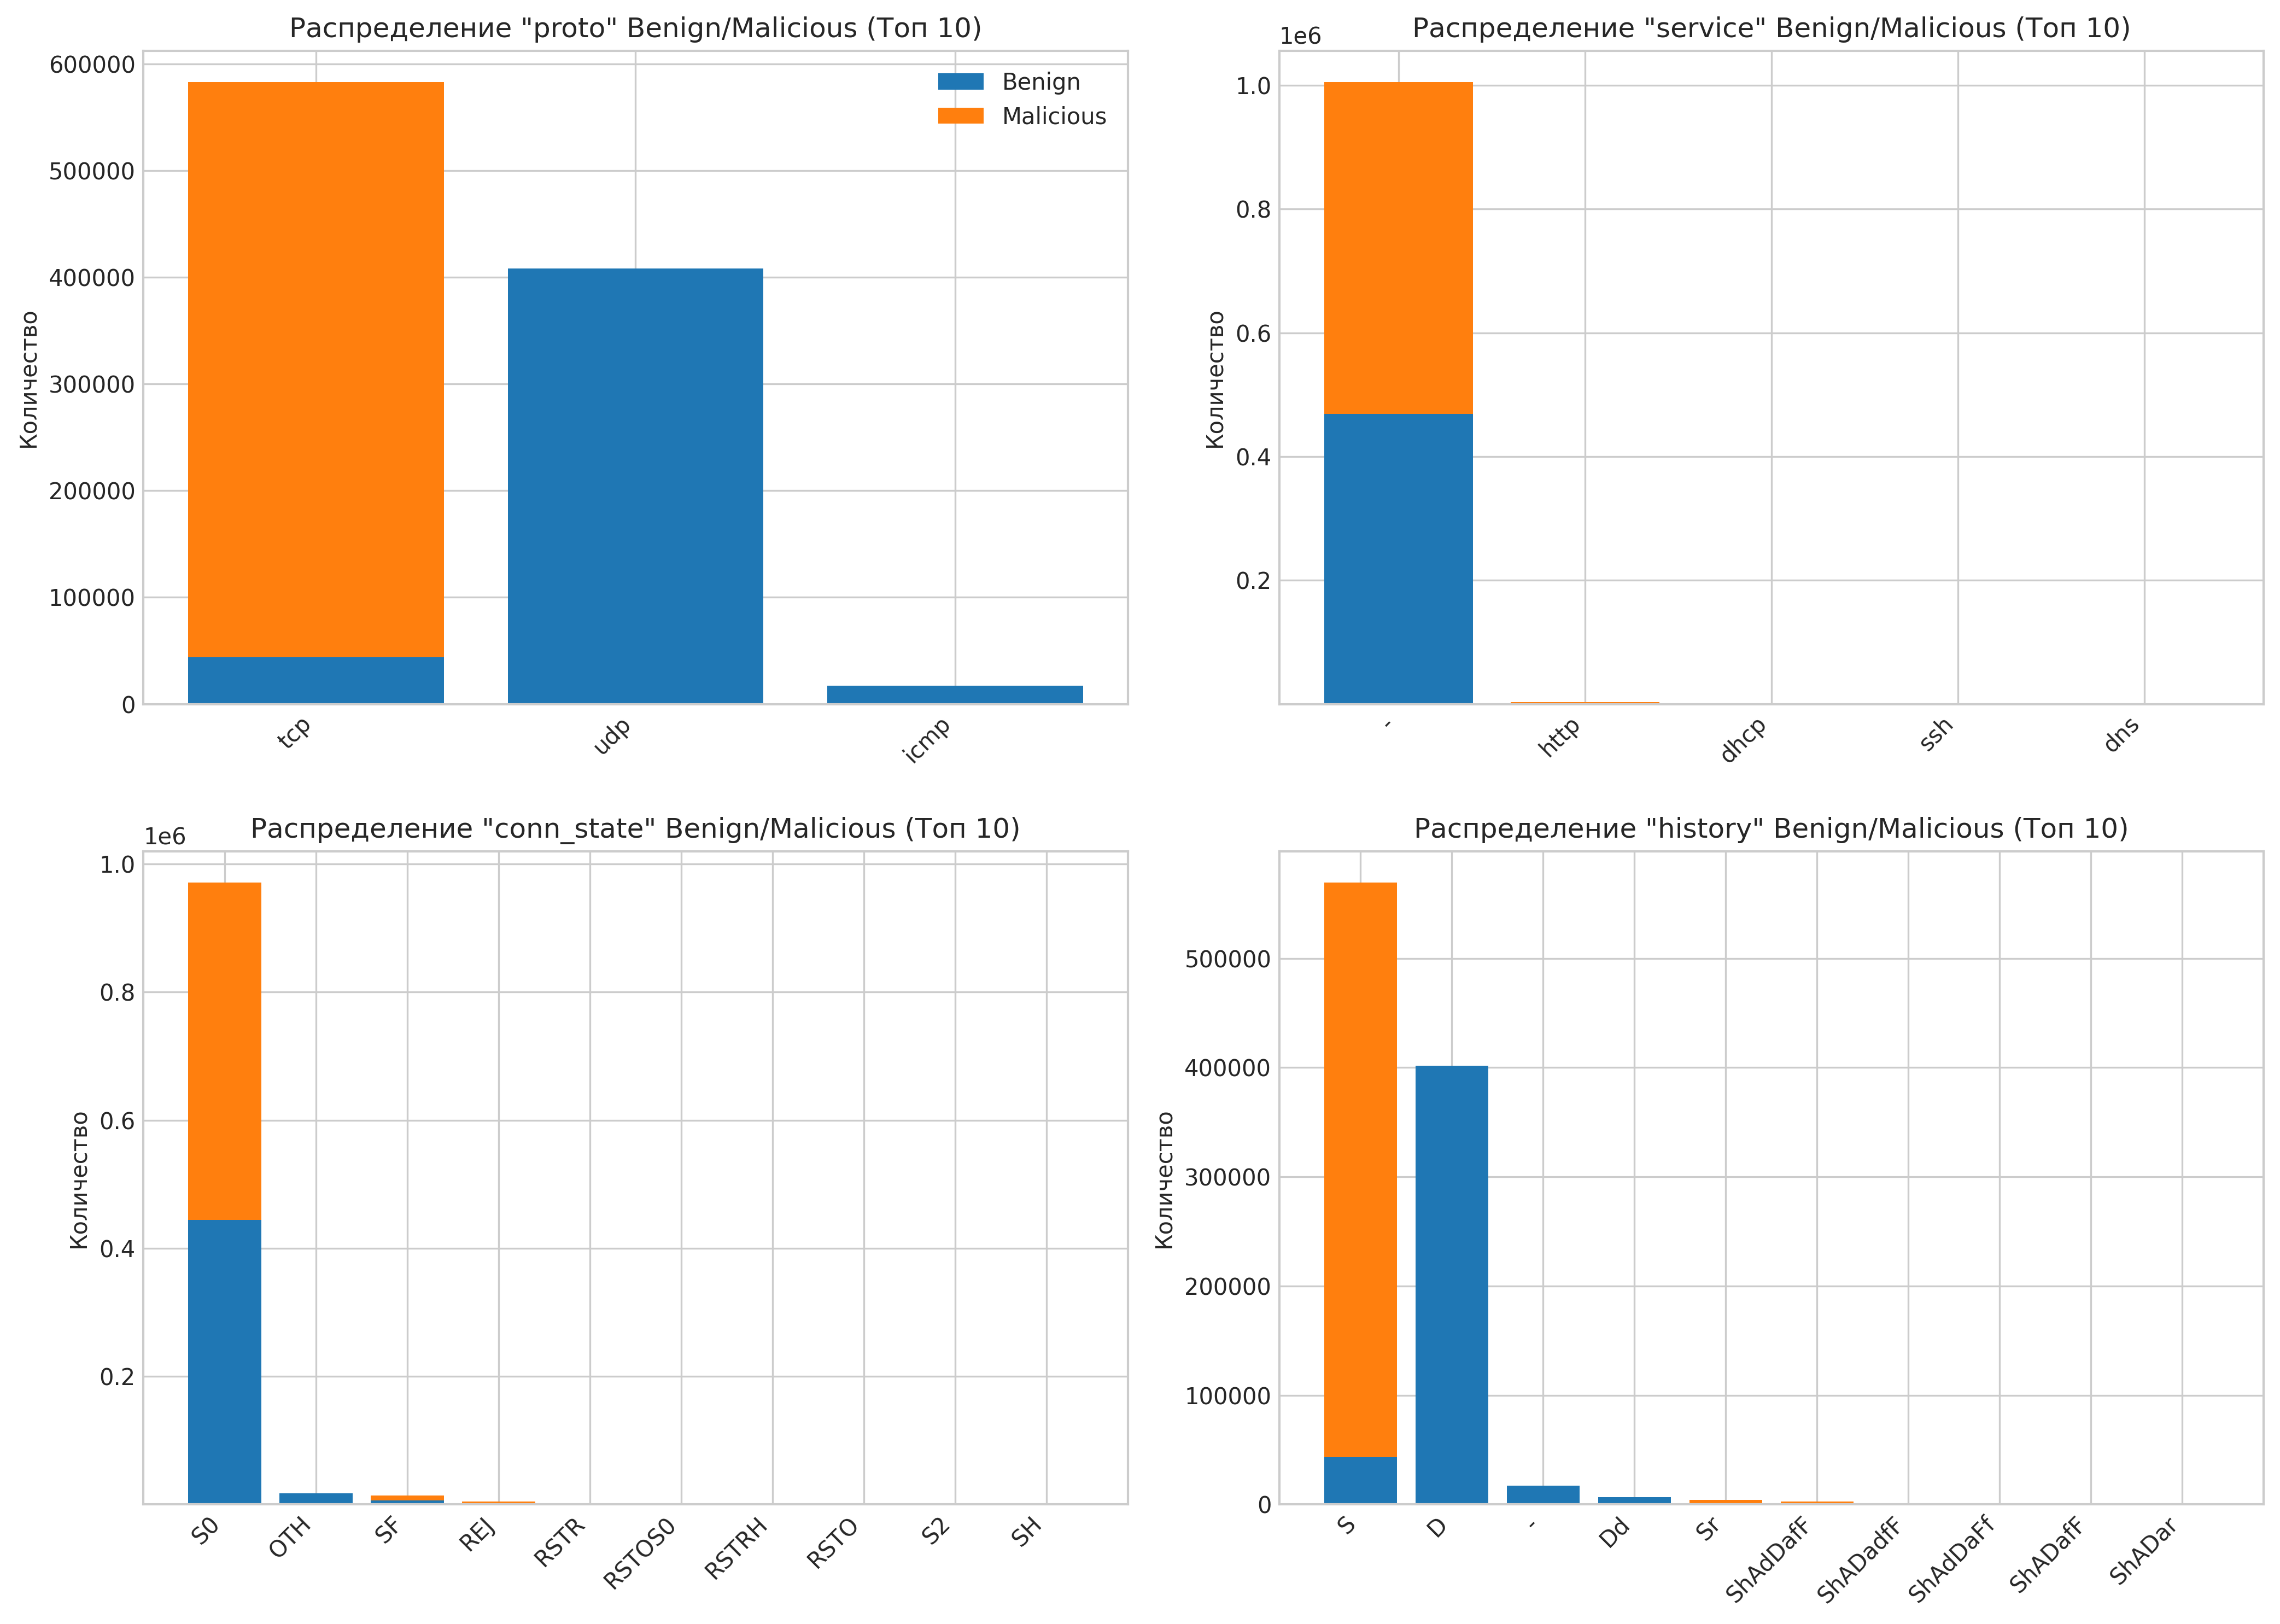

In [15]:
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
axes1 = axes1.flatten()

for ax, col in zip(axes1, cat_cols):
    counts = count_tables[col]
    x = np.arange(len(counts))
    
    benign = counts['Benign'].values
    malicious = counts['Malicious'].values
    
    ax.bar(x, benign, label='Benign')
    ax.bar(x, malicious, bottom=benign, label='Malicious')
    
    ax.set_title(f'Распределение \"{col}\" Benign/Malicious (Топ {TOP_N})')
    ax.set_xticks(x)
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.set_ylabel('Количество')
    if col == cat_cols[0]:
        ax.legend()

fig1.tight_layout()

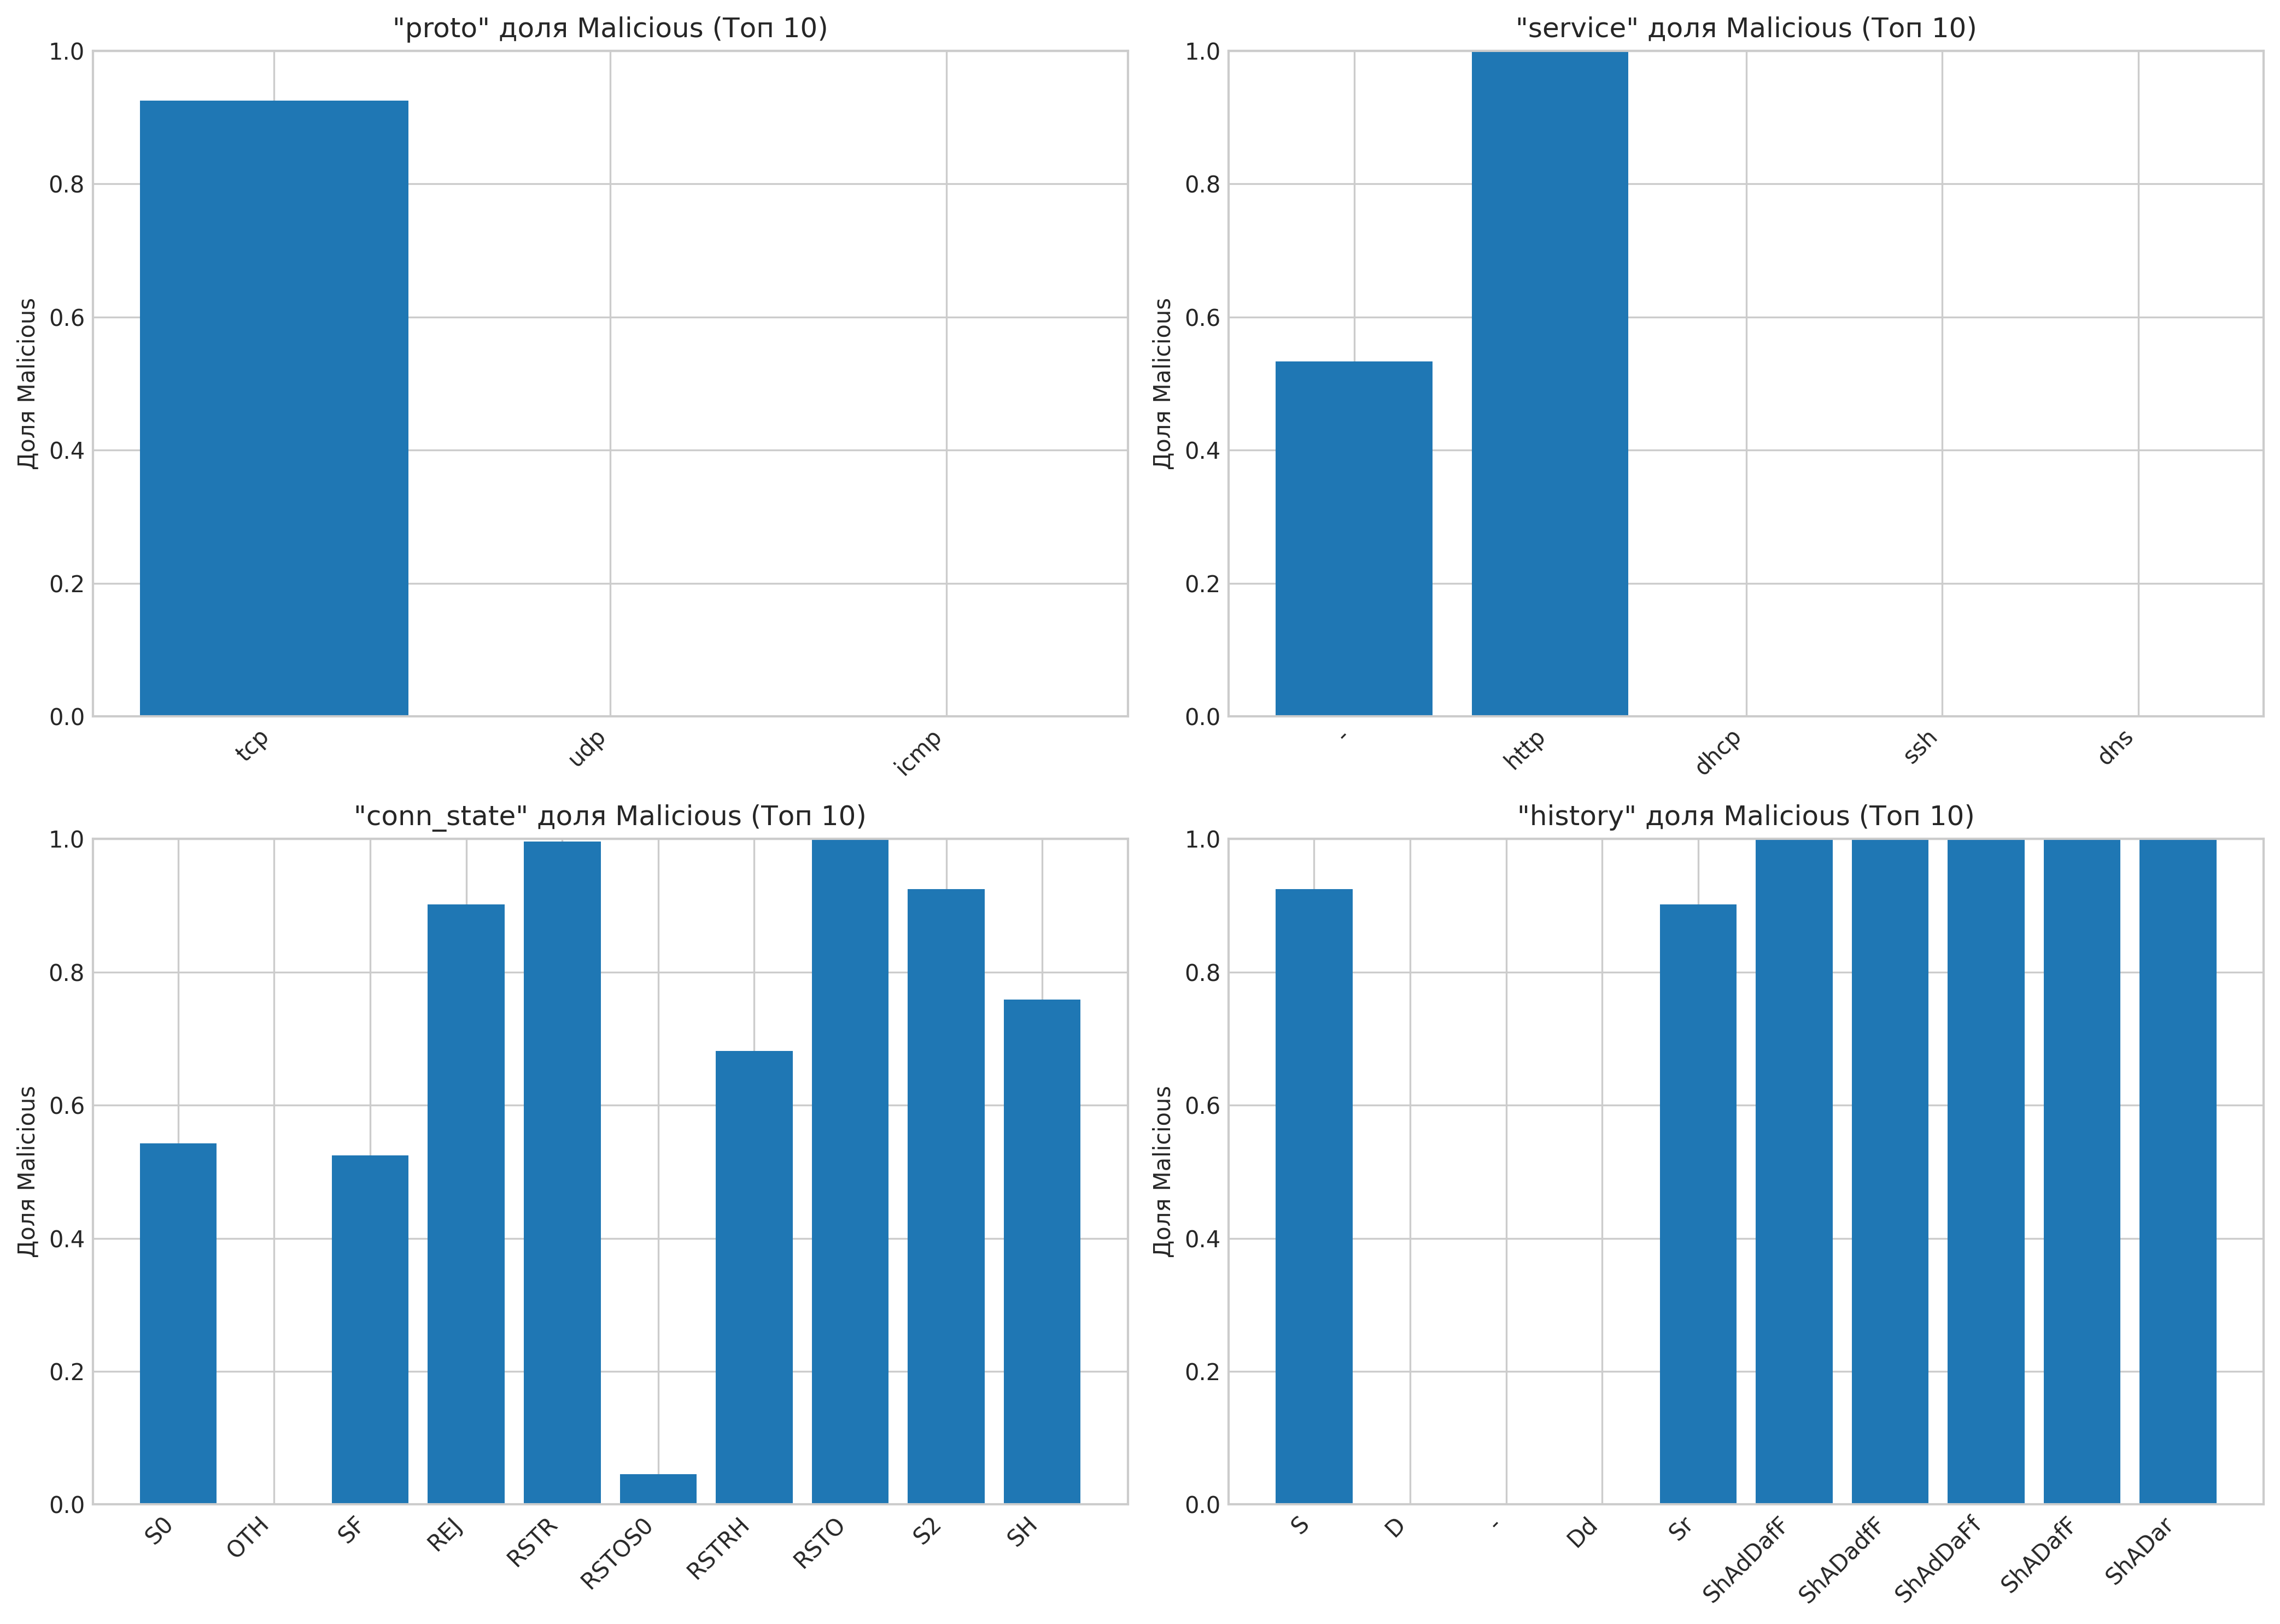

In [16]:
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
axes2 = axes2.flatten()

for ax, col in zip(axes2, cat_cols):
    rates = rate_tables[col]
    x = np.arange(len(rates))
    
    ax.bar(x, rates.values)
    ax.set_ylim(0, 1)
    ax.set_title(f'\"{col}\" доля Malicious (Топ {TOP_N})')
    ax.set_xticks(x)
    ax.set_xticklabels(rates.index, rotation=45, ha='right')
    ax.set_ylabel('Доля Malicious')

fig2.tight_layout()

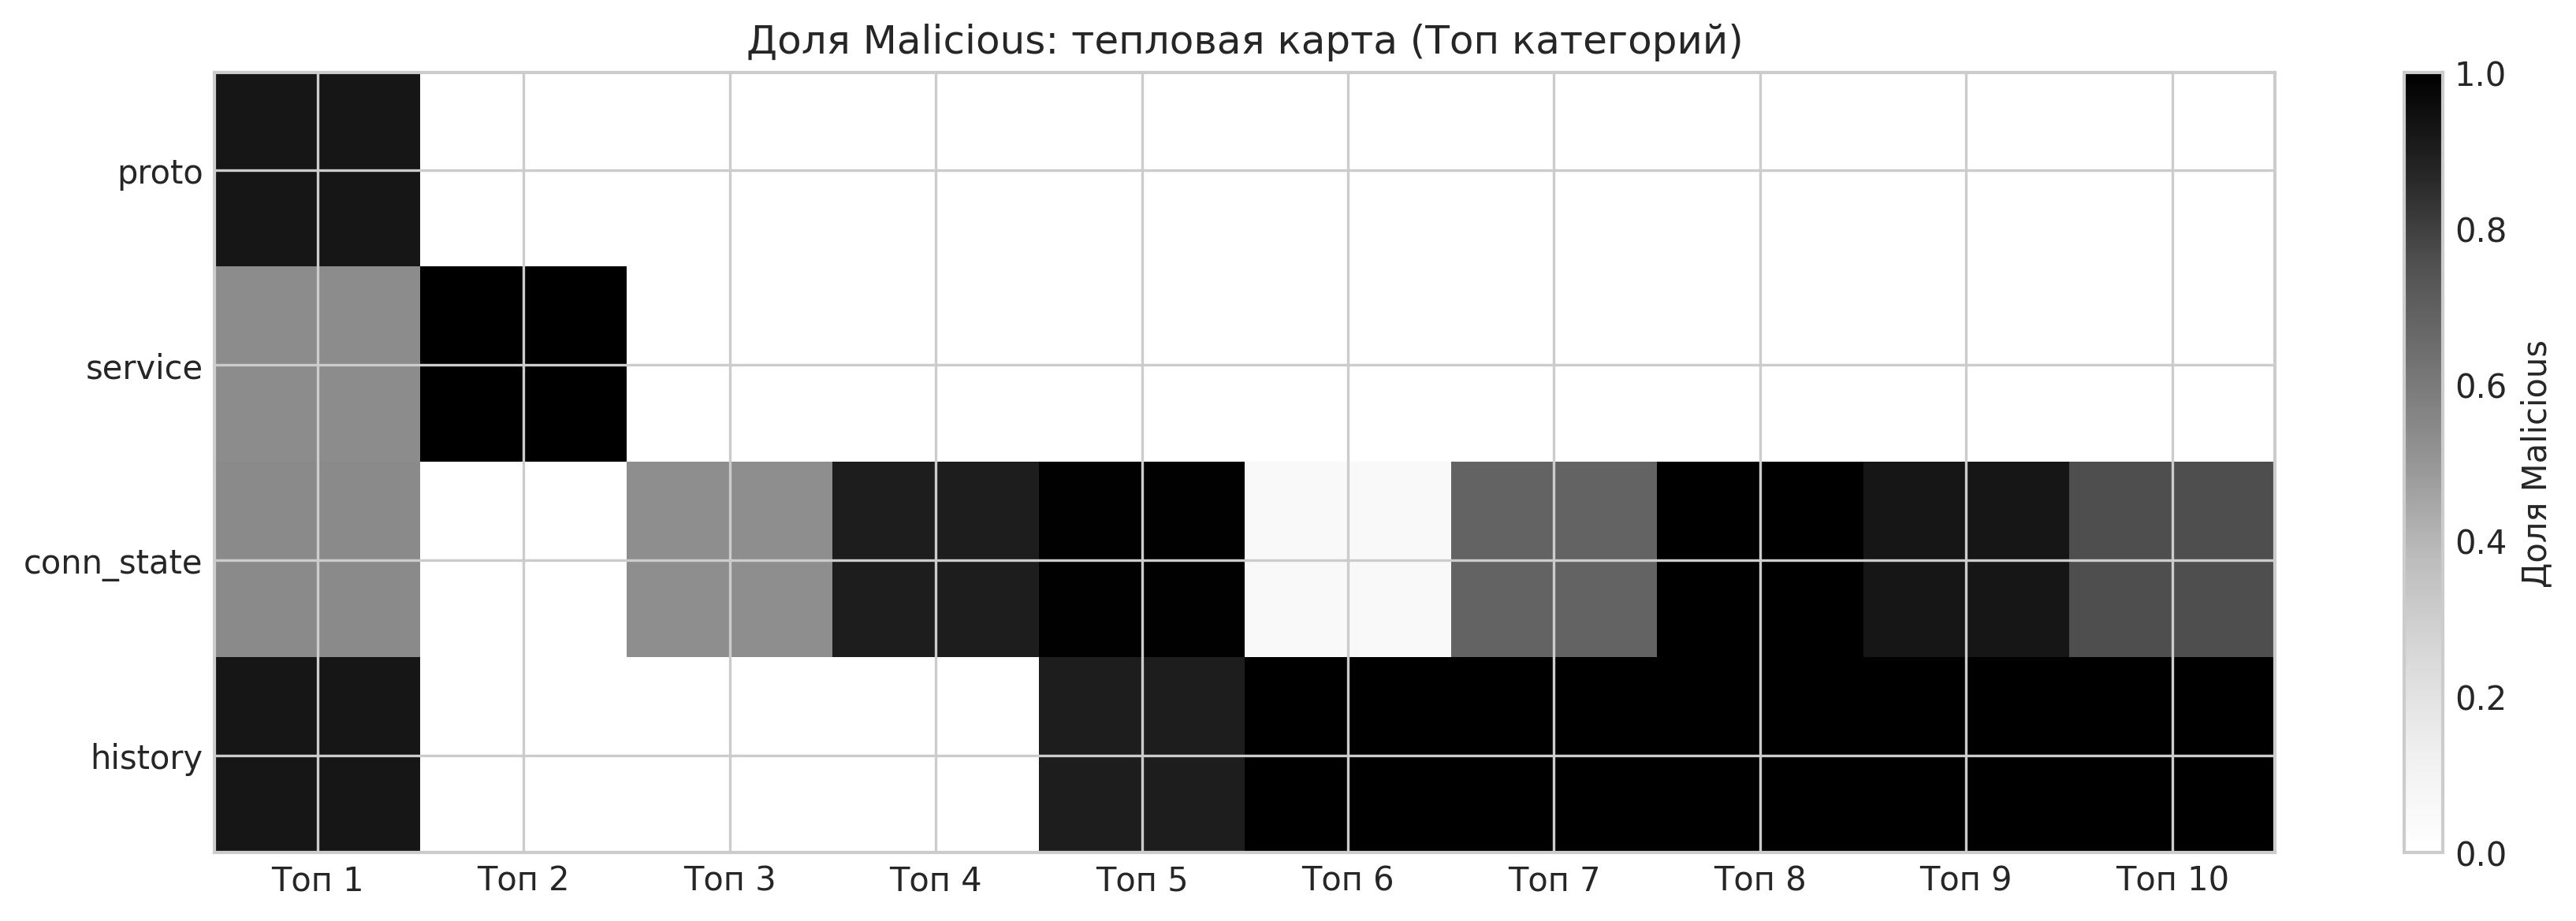

In [17]:
heatmap_df = pd.DataFrame(index=cat_cols, columns=range(TOP_N))

for col in cat_cols:
    rates = rate_tables[col]
    heatmap_df.loc[col, :len(rates)-1] = rates.values

fig3, ax3 = plt.subplots(figsize=(12, 4))
im = ax3.imshow(heatmap_df.astype(float), aspect='auto')

ax3.set_yticks(np.arange(len(cat_cols)))
ax3.set_yticklabels(cat_cols)
ax3.set_xticks(np.arange(TOP_N))
ax3.set_xticklabels([f'Топ {i+1}' for i in range(TOP_N)])
ax3.set_title('Доля Malicious: тепловая карта (Топ категорий)')

cbar = plt.colorbar(im, ax=ax3)
cbar.ax.set_ylabel('Доля Malicious')

fig3.tight_layout()

plt.show()

#### Распределения числовых признаков

In [18]:
numeric_cols = df_copy.select_dtypes(include=["int64", "float64"]).columns.tolist()

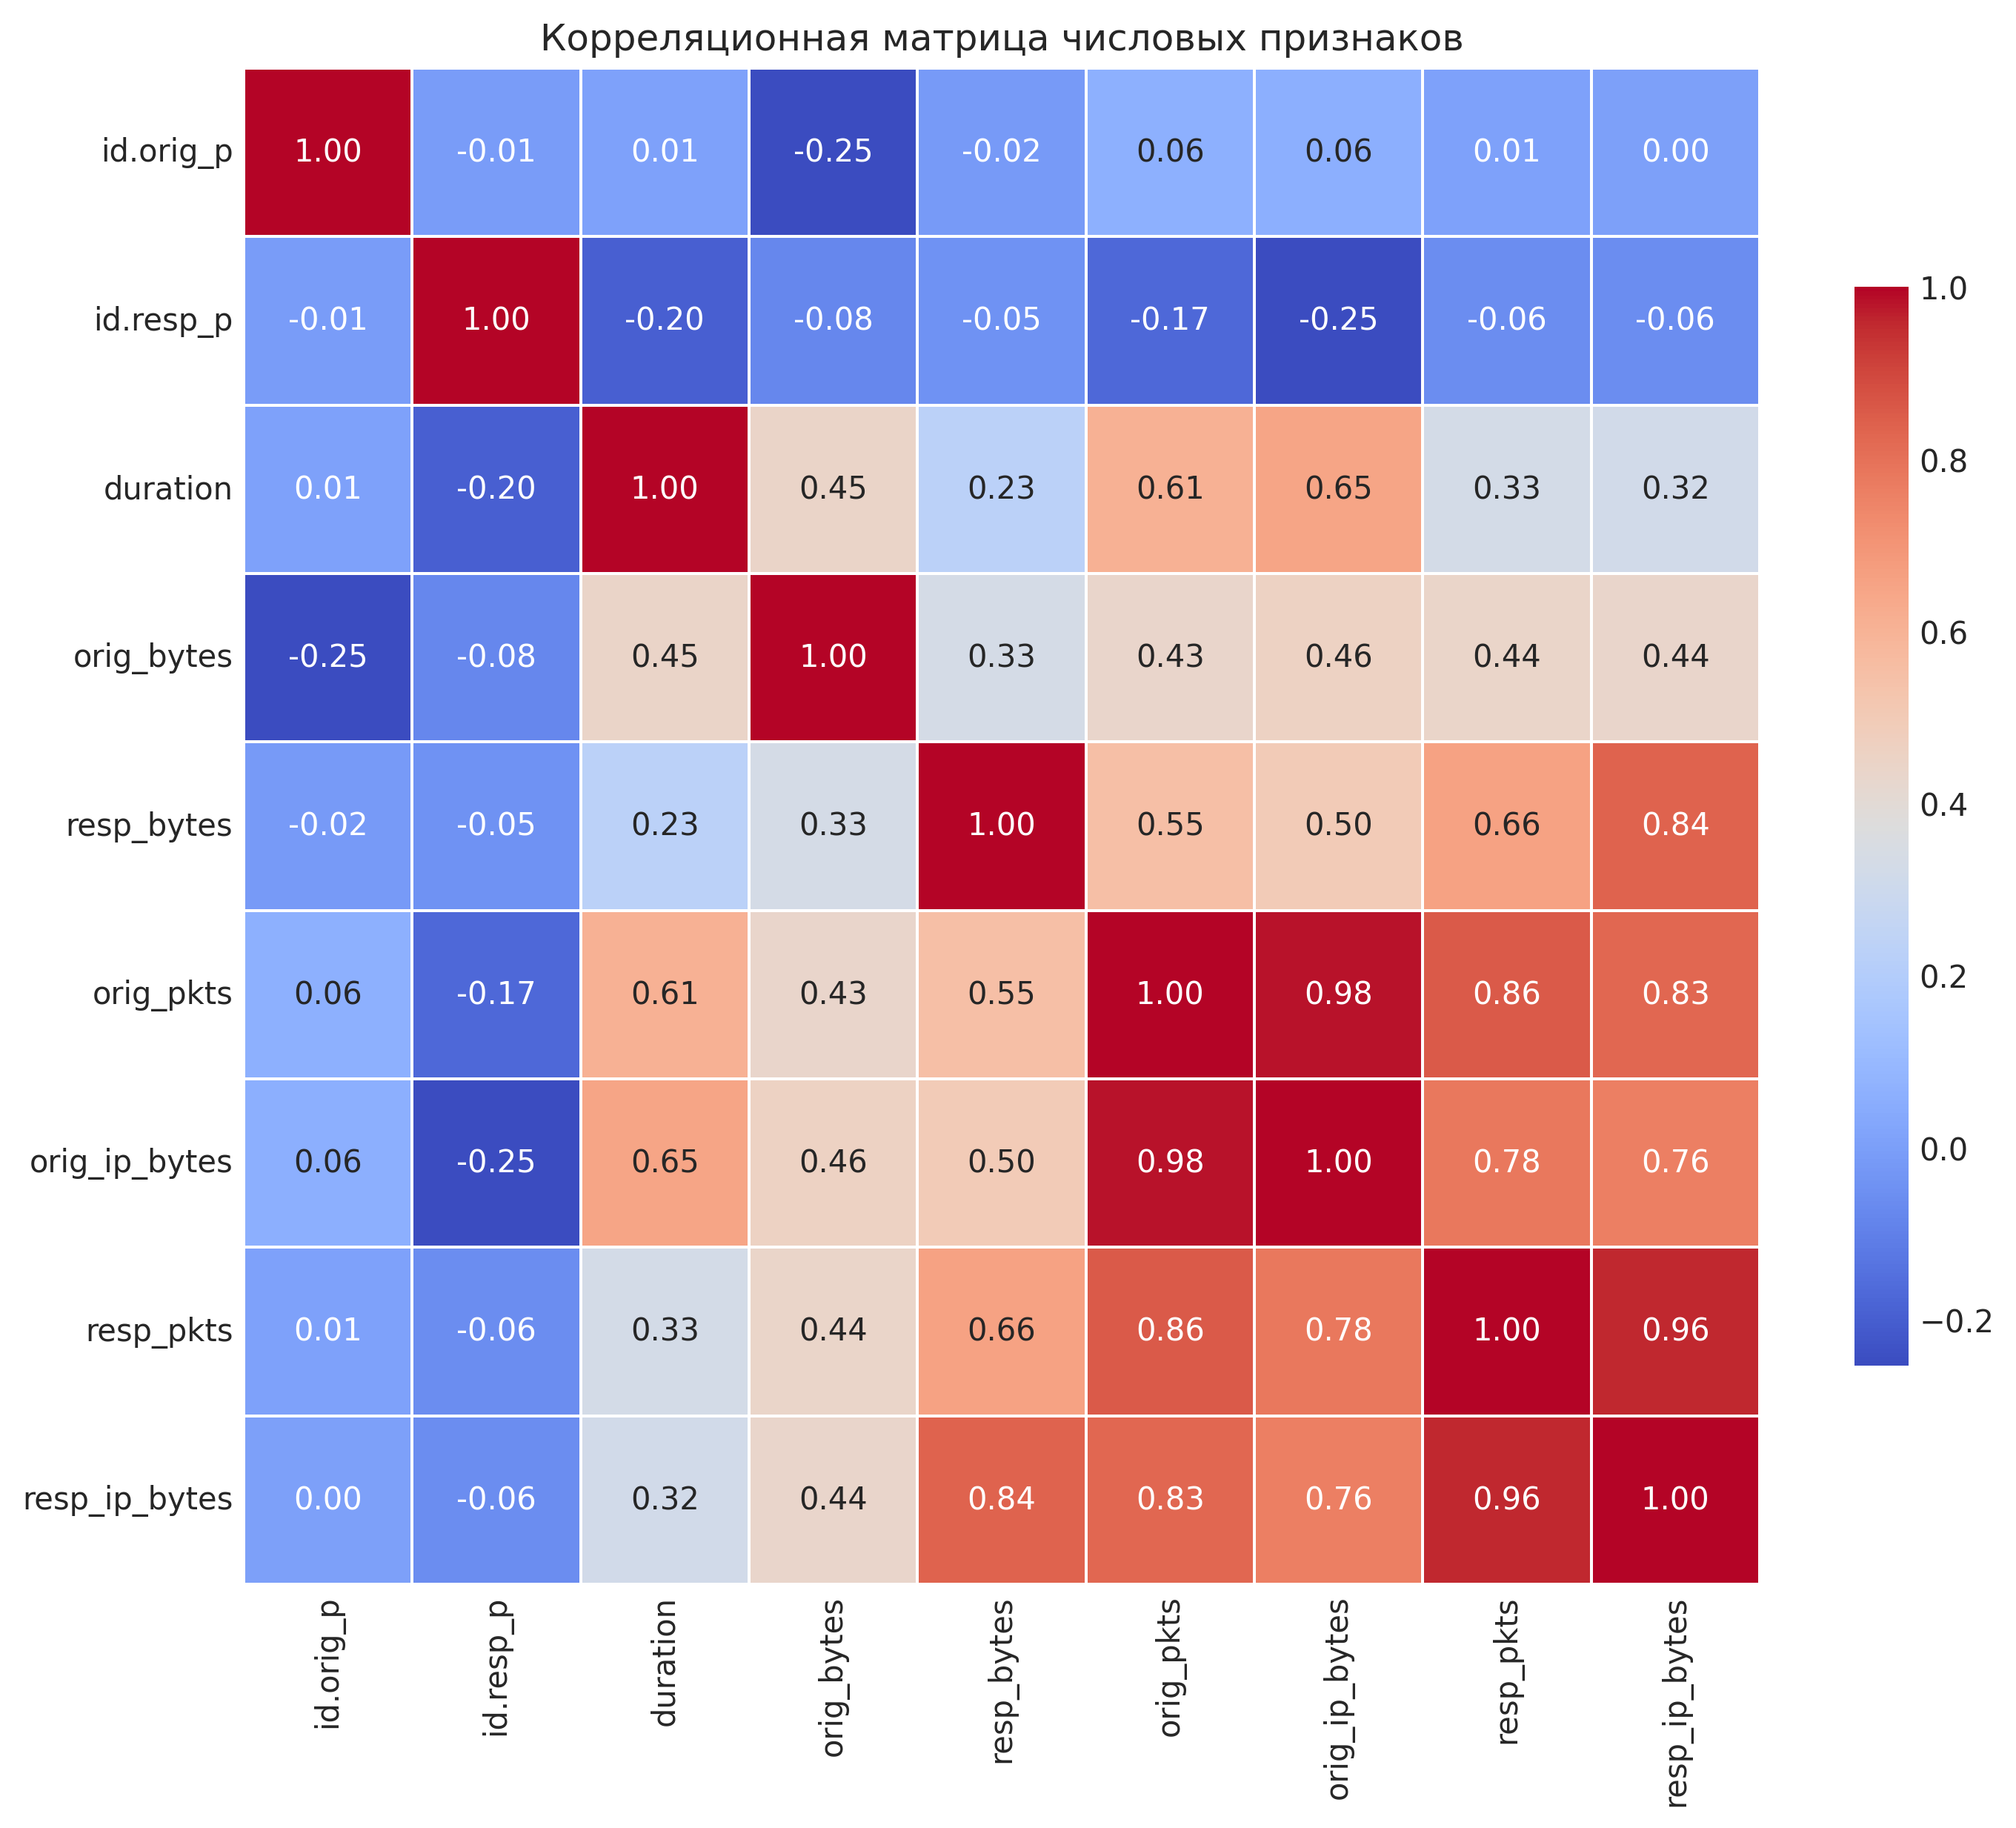

In [19]:
corr = df_copy[numeric_cols].corr(method="pearson")

plt.figure(figsize=(11, 9))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=.5,
    cbar_kws={"shrink": .7},
    square=True
)

plt.title("Корреляционная матрица числовых признаков")
plt.show()

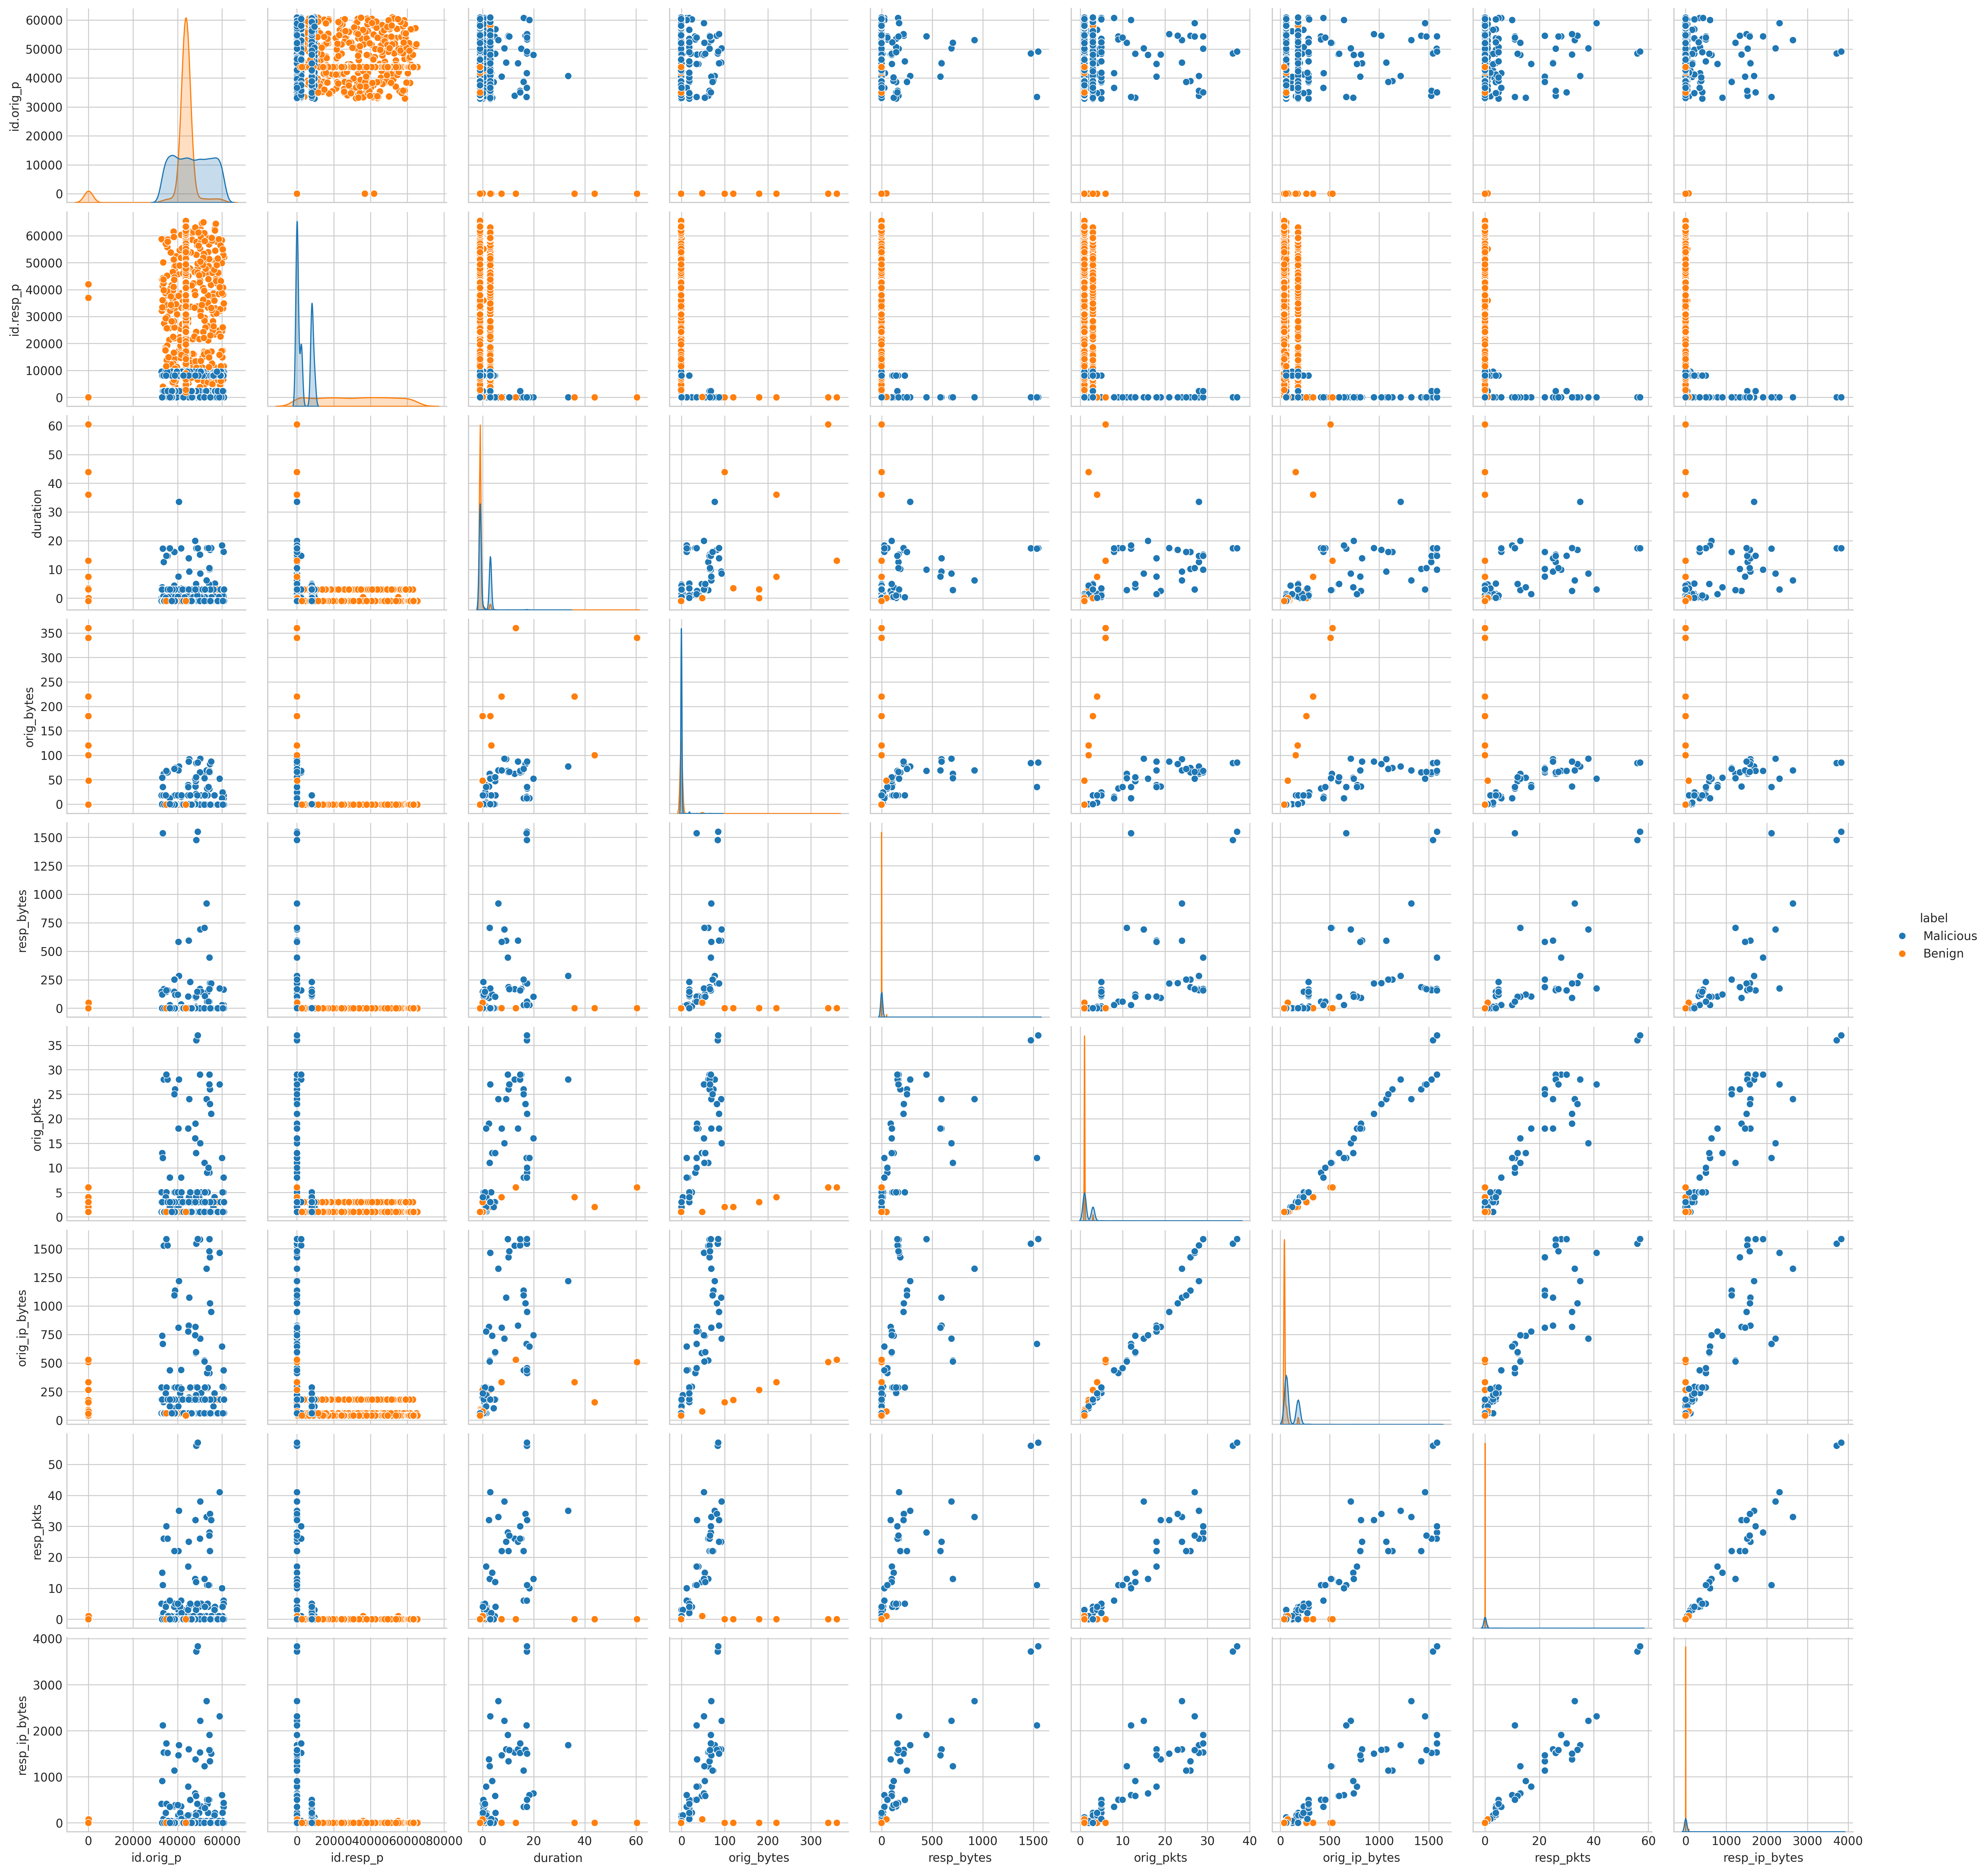

In [20]:
size_sample = 8000
random_state = 42

pair_df = df_copy.sample(n=size_sample, random_state=random_state)

sns.pairplot(
    pair_df,
    vars=numeric_cols,
    hue="label",
)

plt.show()

Первые три признака (порты + duration) практически не связаны с "объёмными" метриками, а последние шесть - это разные способы измерить один и тот же объём трафика.

- `orig_pkts` <-> `orig_ip_bytes`
- `resp_pkts` <-> `resp_ip_bytes`
- `orig_bytes` и `resp_bytes` - почти вложены в IP-байты и тесно связаны с количеством пакетов.

Поэтому такая корреляция вполне естественна.